In [1]:
import numpy as np # linear algebra
import numpy.linalg

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install faraway

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 5.3 MB/s 


In [3]:
import faraway.datasets.snail
snail = faraway.datasets.snail.load()
snail.head()

,water,temp,humid
0,76,20,45
1,64,20,45
2,79,20,45
3,71,20,45
4,72,20,75


In [4]:
print(faraway.datasets.snail.DESCR)


Snail production

Description:

     A study was conducted to optimize snail production for
     consumption. The percentage water content of the tissues of snails
     grown under three different levels of relative humidity and two
     different temperatures was recorded. For each combination, 4
     snails were observed.

Variables:

     A data frame with 24 observations on the following 3 variables.

     ‘water’ percentage water content

     ‘temp’ temperature in C

     ‘humid’ relative humidity

Source:

     Unknown



In [6]:
snail.groupby(['temp', 'humid'])['water'].mean()

temp  humid
20    45       72.50
      75       81.50
      100      97.00
30    45       69.50
      75       78.25
      100      97.75
Name: water, dtype: float64

In [7]:
x0 = pd.Series({
    "temp": 25,
    "humid": 60
})
x0

temp     25
humid    60
dtype: int64

Intuitively, a prediction for x0 -- average of the averages from two respective groups: $\frac{\frac{81.50 + 72.50}{2} + \frac{78.25 + 69.50}{2}}{2} = 75.4375$

In [9]:
import faraway.utils

lmod = smf.ols(
    "water ~ humid + temp",
    data=snail
).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept 52.611  6.853    7.68  0.0000
humid      0.473  0.050    9.40  0.0000
temp      -0.183  0.226   -0.81  0.4273

n=24 p=3 Residual SD=5.547 R-squared=0.81


In [13]:
lmod.get_prediction(x0).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,76.436813,1.316375,73.699262,79.174364,64.580941,88.292685


In [14]:
x1 = pd.Series({
    "temp": 30,
    "humid":75 
})
x1

temp     30
humid    75
dtype: int64

In [15]:
lmod.get_prediction(x1).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,82.622482,1.603461,79.287902,85.957062,70.614695,94.630268


The length of the intervals are more or less the same. </br>
The predictions are close to intuitive ones.

SyntaxError: ignored

How do I make the prediction equal to the intercept? </br>
I need: $$0 = \hat{\beta_{humid}} x_0 +  \hat{\beta_{temp}} x_1$$
which gives a line of solutions.


In [56]:
def get_solution_with_humid(humid):
  c = -lmod.params["humid"] / lmod.params["temp"]
  x = pd.Series({
      "humid": humid,
      "temp": c*humid,
  })
  return x

x3=get_solution_with_humid(15)
lmod.predict(x3)

0    52.610806
dtype: float64

In [57]:
lmod.get_prediction(x3).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,52.610806,4.42631,43.40579,61.815822,37.852763,67.368849


Moving along this line we get different prediction intervals, depending, of course, on how extrapolative the point is.

Text(0.5, 0, 'humidity')

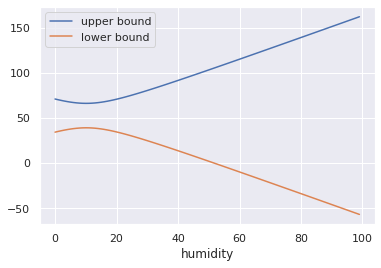

In [49]:
x_range = np.arange(0, 100)
lower = np.empty((100,))
upper = np.empty((100,))

for x in x_range:
  sol = get_solution_with_humid(x)
  frame = lmod.get_prediction(sol).summary_frame()
  lower[x] = frame["obs_ci_lower"]
  upper[x] = frame["obs_ci_upper"]
plt.plot(x_range, upper, label="upper bound")
plt.plot(x_range, lower, label="lower bound")
plt.legend()
plt.xlabel("humidity")

Euristic to obtain the humidity with the narrowest interval: project the median onto the line; or, equivalently, regress the median onto the line. </br>
Alternatively, use the gradient descent -- we see the length of the interval as a function of humidity is convex